In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_gaussian_quantiles

make_gaussian_quantiles <a src="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_gaussian_quantiles.html">ver</a>

In [102]:
N = 1000
X, Y = make_gaussian_quantiles(mean=None, cov=0.1, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)

In [103]:
print("X: ", X.shape, " Y:",Y.shape)
Y = Y[:,np.newaxis]
print("X: ", X.shape, " Y:",Y.shape)

X:  (1000, 2)  Y: (1000,)
X:  (1000, 2)  Y: (1000, 1)


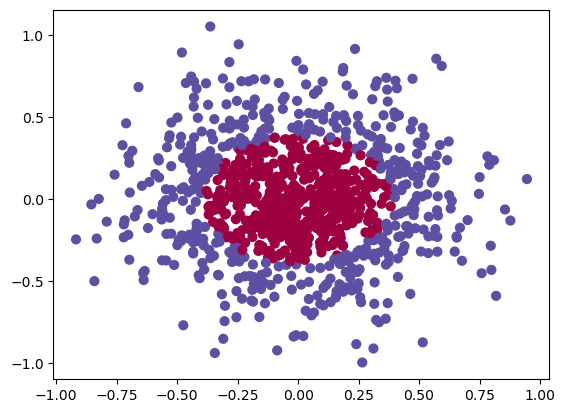

In [104]:
plt.scatter(X[:,0], X[:,1], c=Y[:,0], s=40, cmap=plt.cm.Spectral)

# Funcion de activacion

In [111]:
# Sigmoid
def sigmoid(x, derivate=False):
    if derivate:
        return np.exp(-x)/((np.exp(-x)+1)**2)
    else:
        return 1/(1+np.exp(-x))
# relu(x)
def relu(x, derivate=False):
    if derivate:
        x[x<=0]=0
        x[x>1]=1
        return x
    else:
        return np.piecewise(x, [x<0.0, x>0.0], [0,lambda x:x])
        # return np.array([i if i>0 else 0 for i in x])

# Funcion de perdida

In [107]:
# ERROR CUADRATICO MEDIO
def mse(y_act, y_pred, derivate=False):
    if derivate:
        # Derivar es para optimizar
        return (y_pred - y_act)
    return np.mean((y_pred - y_act)**2)

# Estructura de red neuronal

In [7]:
def init_parameters_deep(layers_dim):
    parameters = {}
    L = len(layers_dim)
    for l in range(0, L-1):
        parameters["W"+str(l+1)] = (np.random.rand(layers_dim[l], layers_dim[l+1])*2)-1
        parameters["b"+str(l+1)] = (np.random.rand(1, layers_dim[l+1])*2)-1 # bayas
    return parameters
     

In [8]:
layers_dims = [2,4,8,1] # 2 features, 4 neuronas, 8 neuronas, 1 neurona
params = init_parameters_deep(layers_dims)

In [ ]:
params

In [9]:
print('X: ',X.shape, '  W1:', params['W1'].shape)
np.matmul(X, params['W1']).shape # X@params['W1']


X:  (1000, 2)   W1: (2, 4)


(1000, 4)

# FORWARD

In [91]:
def forward(x_data, params):
    params['A0'] = x_data                                               # Entrada de valores
    params['Z1'] = np.matmul(params['A0'], params['W1']) + params['b1'] # Suma ponderada (Producto punto)
    params['A1'] = relu(params['Z1'])                                   # Funcion de activacion

    params['Z2'] = np.matmul(params['A1'], params['W2']) + params['b2'] # Suma ponderada (Producto punto)
    params['A2'] = relu(params['Z2'])                                   # Funcion de activacion

    params['Z3'] = np.matmul(params['A2'], params['W3']) + params['b3'] # Suma ponderada (Producto punto)
    params['A3'] = sigmoid(params['Z3'])                                # Funcion de activacion
    # sigmoid, al tener en A3 solo 2 clases se debe definir que clase es, porque quiero que me dija la distribucion estadistica entre uno otro

    output = params['A3']

    # print(output.shape,'\n', "output") # El error de perdida debe ser altisima
    return output

# BACKPROPAGATION
## Evaluacion de perdida
### Error imputado
$$\delta^L = \frac{\partial C}{\partial a^L} * \frac{\partial a^L}{\partial z^L}$$

### Backpropagation ultima capa

$$\frac{\partial C}{\partial b^L} = \delta^L * \frac{\partial z^L}{\partial b^L} = \delta^L$$
$$\frac{\partial C}{\partial w^L} = \delta^L * \frac{\partial z^L}{\partial w^L} = \delta^L * a_i^{L-1}$$

### Backpropagation capa anterior
$$\frac{\partial C}{\partial w^{L-1}} = \delta^L * \frac{\partial z^L}{\partial a^{L-1}} * \frac{\partial a^{L-1}}{\partial z^{L-1}} * \frac{\partial z^{L-1}}{\partial w^{L-1}} = \delta^L * W^L * \frac{\partial a^{L-1}}{\partial z^{L-1}} * a_i^{L-2}$$

In [125]:
def backpropagation(y_data, params, output):
        ### Backpropagation ultima capa
        # params['dZ3'] = mse(y_data, output, True) * sigmoid(params['A3'], True)  # Error Inputado
        params['dZ3'] = mse(y_data, output, True) * sigmoid(params['Z3'], True)  # Error Inputado
        params['dW3'] = np.matmul(params['A2'].T,params['dZ3'])                # Backpropagation

        # Backpropagation capas anteriores
        params['dZ2'] = np.matmul(params['dZ3'], params['W3'].T) * relu(params['Z2'], True)  # dz2 = d^l*W^l*der(a^l-1/z^l-1)
        params['dW2'] = np.matmul(params['A1'].T,params['dZ3'])                # (dz2) * a^l-2

        params['dZ1'] = np.matmul(params['dZ2'], params['W2'].T) * relu(params['Z1'], True)  # dz2 = d^l*W^l*der(a^l-1/z^l-1)
        params['dW1'] = np.matmul(params['A0'].T,params['dZ1'])                # (dz2) * a^l-2

# GRADIENT DESCENT

In [93]:
def gradient_descent(params, learning_rate):
    params['W3'] = params['W3'] - params['dW3'] * learning_rate                                     # learning rate
    params['b3'] = params['b3'] - (np.mean(params['dZ3'], axis=0, keepdims=True)) * learning_rate   # bayas

    params['W2'] = params['W2'] - params['dW2'] * learning_rate                                     # learning rate
    params['b2'] = params['b2'] - (np.mean(params['dZ2'], axis=0, keepdims=True)) * learning_rate   # bayas

    params['W1'] = params['W1'] - params['dW1'] * learning_rate                                     # learning rate
    params['b1'] = params['b1'] - (np.mean(params['dZ1'], axis=0, keepdims=True)) * learning_rate   # bayas

In [109]:
def train(x_data, y_data, params, learning_rate, training=True):
    output = forward(x_data, params)
    if training:
        backpropagation(y_data, params, output)
        gradient_descent(params, learning_rate)
    return output

In [123]:
layers_dims = [2,4,8,1] # 2 features, 4 neuronas, 8 neuronas, 1 neurona
params = init_parameters_deep(layers_dims)
errores = []

for _ in range(60000):
    output = train(X,Y, params,0.001, True)
    if _%50 ==0:
        print(mse(Y,output))
        errores.append(mse(Y,output))

0.2895601917709024
0.23635188094200082
0.22770592581516627
0.2213499284440223
0.2164203780135722
0.21247679338743578
0.2095349869766169
0.20797754992023904
0.20800616923753296
0.20985311185738414
0.21440452989082961
0.22042265225096816
0.22289618446084933
0.22440775771703136
0.2328281223291134
0.26335434821009257
0.26207011608713005
0.26200819395572944
0.2619403506588126
0.26187285240293257
0.26180569785419433
0.26173888567924586
0.2616724145453367
0.26160628312037365
0.2615404900729781
0.2614750340725408
0.2614099137892781
0.26134512789428527
0.26128067505959107
0.26121655395821053
0.2611527632641979
0.2610893016526982
0.261026167799999
0.2609633603835809
0.260900878082168
0.2608387195757769
0.2607768835457663
0.2607153686748848
0.260654173647319
0.26059329714874013
0.26053273786635134
0.2604724944889331
0.2604125657068888
0.26035295021228944
0.26029364669891775
0.2602346538623118
0.26017597039980866
0.2601175950105858
0.2600595263957036
0.26000176325814695
0.25994430430286514
0.25988

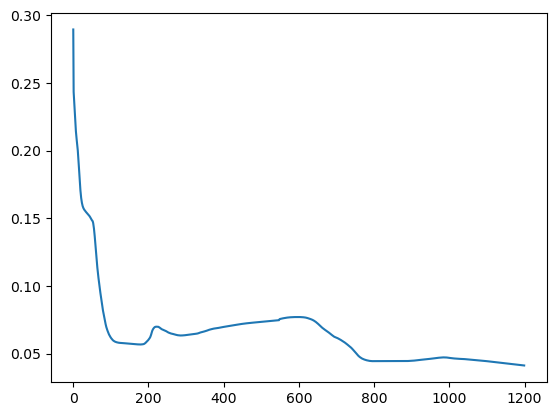

In [118]:
plt.plot(errores)

In [120]:
data_test = (np.random.rand(1000,2)*2)-1
y = train(data_test, Y, params, 0.0001, False)
y = np.where(y>=0.5,1 ,0)

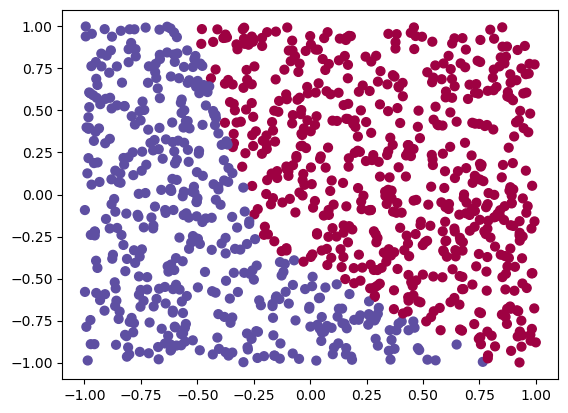

In [122]:
plt.scatter(data_test[:,0], data_test[:,1], c=y[:,0], s=40, cmap=plt.cm.Spectral)